In [1]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import pandas as pd
import os

import tensorflow as tf

from feature_processing import signal as basics


2022-09-19 16:27:29.441020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Signal Params

sf = 200

main_freq = [23, None]
labels = [1, 2]

channels_tokeep = "all"
#channels_tokeep = [2,3]

# Processing Params

load_many = True

bp_lo = 1
bp_hi = 70
notch = 50

load_validation = True
model_iter = 3

command_simulation = True

### Validation Set

In [3]:
signal_pd_val, tag_column_val, signal_name_val, signal_dir_val, signal_path_val = basics.build_dataframe(initial_dir="/Users/gastoncavallo/Desktop/Facultad/PI/Scripts/Command slider test")

signal_np_val, signal_pd_tonp_val = basics.signal_cleaning(signal_pd_val, labels = labels, just_np = True)

signal_np_val = signal_pd_val[["Ch1", "Ch2", "Ch3", "Ch4"]].values.T
signal_val = basics.preprocess(signal_np_val, bp_flo = bp_lo, bp_fhi = bp_hi, f_notch = notch)
    
    
timestamps_dict_val, timestamps_list_val = basics.timestamps_loc(signal_pd_tonp_val, tag_column_val, labels = labels)
    

### Model

In [4]:
#Manualmente asigno el nombre de cada modelo:
    
element = "model_own1"
model = tf.keras.models.load_model("/Users/gastoncavallo/Desktop/Resultados 40 epocas/Full train 40 epoch/trained_models/" + element)


2022-09-19 16:27:56.084386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
lista_reshape = [signal_val[np.newaxis,i-512:i ,:] for i in range(512, signal_val.shape[0], 8)]
signal_reshape = np.concatenate(lista_reshape, axis = 0)

#En caso de tl poner tl = True
tl = False
def modificar_matriz(original, dimnec1, dimnec2, dimnec3): #para acomodar la señal al input necesario por las redes de tl
    
    new = original

    while dimnec1 > (new.shape[1]):
        new = np.append(new, new, axis = 1)
    while dimnec2 > (new.shape[2]):
        new = np.append(new, new, axis = 2)
    
    if dimnec3 != None:
        new = np.expand_dims(new, axis = 3)   
        new_copy = new.copy()
        
        while dimnec3 > (new.shape[3]):
              new = np.append(new, new_copy, axis = 3)
    
    return new
if tl:
    signal_reshape = modificar_matriz(signal_reshape, 75, 75, 3)
    


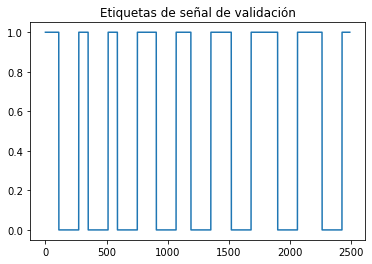

In [6]:
#Ploteo señal de validación
gt = signal_pd_val["mlp_labels"].replace([99,2,1],[1,0,0]).values[512::8] #probar [:-512:8] y [256:-256:8]

plt.figure()
plt.title("Etiquetas de señal de validación")
plt.plot(gt)

plt.savefig("/Users/gastoncavallo/Desktop/Resultados 40 epocas/Etiquetas_de_validación.jpg")

78/78 [==============================] - 1s 5ms/step


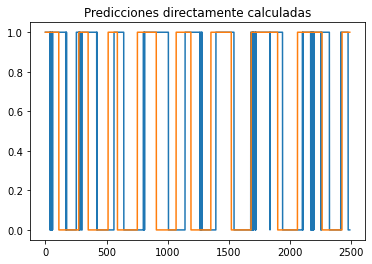

In [6]:
#a signal_reshape la paso por el modelo y con eso obtengo mi vector de predicciones
pred_onehot = model.predict(signal_reshape) #predicciones crudas en onehot, falta aplicar el buffer
preds = pred_onehot.argmax(axis = 1)

gt = signal_pd_val["mlp_labels"].replace([99,2,1],[1,0,0]).values[512::8] #probar [:-512:8] y [256:-256:8]

#al final tirar: signal_reshape.shape , gt.shape, preds.shape
#deberìan ser: N,512,4 - N - N

#si esto esta bien lo de abajo se borra
#medir el tiempo que tarda en hacer esto

plt.figure()
plt.title("Predicciones directamente calculadas")
plt.plot(preds)
plt.plot(gt)
plt.savefig("/Users/gastoncavallo/Desktop/Resultados 40 epocas/Comparación.jpg")

## METRICAS

In [7]:
#Marco eventos en los array
def events(gt, preds):
    gt_events=[[],[]] #la idea es en la posición 0 marcar la ubicación de las bajadas (persona mirando) y en la 1 las subidas (persona deja de mirar)
    preds_events=[[],[]]

    for i in range(1, len(gt)):
        if gt[i] != gt[i-1]:
            gt_events[gt[i]].append(i) #uso el valor de gt[i] que puede ser 0 o 1 para indicar la posición en gt_events
    for i in range(1, len(preds)):
        if preds[i] != preds[i-1]:
            preds_events[preds[i]].append(i)  
    return (preds_events, gt_events)



#Cálculo delay de bajada y subida (Cuánto demora entre que la persona empieza a mirar y el equipo hace la primer predicción)

def delay(gt_events, preds_events):
    
    delay_b = [] 
    delay_s = []
    for b in gt_events[0]:
        first = True
        for bp in preds_events[0]:
            if bp > b and first:
                delay_b.append(bp - b) 
                first = False
                
    for s in gt_events[1]:
        first = True
        for sp in preds_events[1]:
            if sp > s and first:
                delay_s.append(sp-s)
                first = False
                
    #Normalizo el tiempo
    #Cálculo promedio de tiempo en bajada de gt: Persona mirando.
    tb = []
    for i in range(len(gt_events[0])): #Recorro las bajadas
        tb.append(gt_events[1][i] - gt_events[0][i]) #Por cada bajada calculo el tiempo que se queda hasta que sube
    ref = mean(tb)
    
    return((mean(delay_b)/ref), (mean(delay_s)/ref))

#Calculo de Inestabilidad - Falsos pos - Falsos neg
def estabilidad(gt_events, preds_events):
    inest = []
    falsos_pos = []
    falsos_neg = []

    def count_events(a, b): #cuento las eventos entre el rango a,b [a y b pueden ser subidas o bajadas]
        count_sub = 0
        count_baj = 0
        r1 = 0
        r2 = 0
        if a<b: #estoy en subida y cuento subidas, o estoy en bajadas y cuento bajadas.
            for r1 in preds_events[1]:
                if r1>a and r1<b:
                    count_sub +=1 
            for r2 in preds_events[0]:
                if r2>a and r2<b:
                    count_baj +=1

        else: #estoy en bajada y cuento subida o estoy en subida y cuento bajada
            for r1 in preds_events[1]:
                if r1>b and r1<a: #en bajada cuento subida
                    count_sub +=1
            for r2 in preds_events[0]:
                if r2>b and r2<a: #en subida cuento bajada
                    count_baj +=1
        return (count_sub, count_baj)

    i=0
    j=0

    while  j<len(gt_events[1]) and i<len(gt_events[0]):
        if j==i: #Significa que estamos en subida
            inest.append(count_events(gt_events[1][j],gt_events[0][i])[0]) #Cuento subidas = Inest (ideal = 1)
            falsos_pos.append(count_events(gt_events[0][i],gt_events[1][j])[1]) #Cuento bajadas = Falsos pos (ideal = 0)
            j+=1
        else:   #bajada
            inest.append(count_events(gt_events[0][i],gt_events[1][j])[1]) #cuento bajadas = Inest (ideal =1)
            falsos_neg.append(count_events(gt_events[1][j],gt_events[0][i])[0]) #cuento subidas = Falsos neg(ideal =0)
            i+=1
    
    return(mean(inest), mean(falsos_pos), mean(falsos_neg))

def eval_metrics(gt, preds, return_pd = False):
    preds_events, gt_events = events(gt, preds)
    delay_b, delay_s = delay(gt_events, preds_events)
    inest, falsos_pos, falsos_neg = estabilidad(gt_events, preds_events)
    
    if return_pd:
        return pd.DataFrame([[delay_s, delay_b, inest, falsos_pos, falsos_neg]], columns = ["Delay subida",
                                                                                                    "Delay bajada",
                                                                                                   "Inestabilidad",
                                                                                                   "Falsos positivos",
                                                                                                   "Falsos negativos"])
        
    else:
        return(delay_s, delay_b, inest, falsos_pos, falsos_neg)
    
    
    
    

# VALIDATION

In [12]:
def plot_command(percent, buff_size, return_pd = False):
    fig, axs = plt.subplots(1, 3) # not efficient bc generates new figures but for update its a HUGE workaround
    fig.set_figheight = 5
    fig.set_figwidth = 10
    time_predictions = []
    for j in range(len(preds)):
        if j < buff_size:
            time_predictions.append(1)
        else:
            count = 0
            for b in range(buff_size, -1, -1):
                if preds[j-b] == 1:
                    count+=1
                    
            if (count/buff_size)*100 > percent:
                time_predictions.append(1)
            else:
                time_predictions.append(0)
                
    metrics = eval_metrics(gt, time_predictions, return_pd)
    if return_pd:
        return metrics 
    
    axs[0].plot(time_predictions)
    axs[0].plot(gt)

    axs[1].bar(list(range(2)), metrics[:2], tick_label=['DS', 'DB'])
    axs[2].bar(list(range(3)), metrics[2:], tick_label=['Inest', 'FP', 'FN'])

    plt.show()

interact(plot_command, percent = widgets.IntSlider(value=85,
                                                    min=10,
                                                    max=100,
                                                    step=1,
                                                    description='%:',
                                                    disabled=False,
                                                    continuous_update= False,
                                                    orientation='horizontal',
                                                    readout=True,
                                                    readout_format='d'
                                                ), buff_size = widgets.IntSlider(value=20,
                                                                                min=5,
                                                                                max=100,
                                                                                step=1,
                                                                                description='Samples:',
                                                                                disabled=False,
                                                                                continuous_update= False,
                                                                                orientation='horizontal',
                                                                                readout=True,
                                                                                readout_format='d'
                                                                                ), return_pd = widgets.IntSlider(disabled=True)
        )

interactive(children=(IntSlider(value=85, continuous_update=False, description='%:', min=10), IntSlider(value=…

<function __main__.plot_command(percent, buff_size, return_pd=False)>

,Delay subida,Delay bajada,Inestabilidad,Falsos positivos,Falsos negativos
0,0.425826,0.343582,1.533333,1.125,2


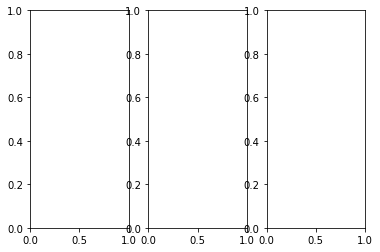

In [13]:
#En este bloque escribo la mejor combinación de % y Samples reemplazar el nombre del modelo en cuestion en el path

metrics = plot_command(78, 18, True)
metrics

In [ ]:
#QUE ME GUARDE UN csv POR CADA MODELO (16 MODELOS)
metrics.to_csv("/Users/gastoncavallo/Desktop/Resultados 40 epocas/Full train 40 epoch/metrics/Metricas_eval/modeltl_resnet50.csv")

In [ ]:
#Ultimo bloque, me arma un solo csv con los datos de todos los modelos
lista_table_metrics = []
metrics_path = "/Users/gastoncavallo/Desktop/Resultados 40 epocas/Full train 40 epoch/metrics/Metricas_eval"
metrics_list = os.listdir(metrics_path)

for met in metrics_list:
    if ".csv" in met:
        lista_table_metrics.append(pd.read_csv(os.path.join(metrics_path, met), index_col=0))

full_table_metrics = pd.concat(lista_table_metrics)
full_table_metrics.to_csv(os.path.join(metrics_path, "full_table_metrics_eval.csv"))   